<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FashionMNIST" data-toc-modified-id="FashionMNIST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FashionMNIST</a></span></li></ul></div>

# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [ ]:
import os
import wandb
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as nn_funcs
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import *

Глобальные переменные. 

In [ ]:
TRAIN_BATCH = 64
TEST_BATCH = 512  
N_IN = 28*28
N_OUT = 10
LR = 0.01
NUM_WORKERS = 2
N_EPOCHS = 10
SEED = 42
MNISTF_MEAN = 0.2859
MNISTF_STD = 0.3530
PARAM_DICT = {'epochs':N_EPOCHS, 'train_batch':TRAIN_BATCH, 'num_workers':NUM_WORKERS, 
              'lr':LR, 'seed':SEED, 'classes':N_OUT}

Логинимся с wandb

In [ ]:
WNB_FLAG = True
API_KEY = '1e336653f3b7f6e592b690df27569339f08234c2'
WNB_PROJECT = 'MNIST Fashion'
WNB_LOGIN = 'majesty50'

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

seed_all(SEED)

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(MNISTF_MEAN, MNISTF_STD)
                      ])

Загружаем данные.

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = TRAIN_BATCH, 
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = TEST_BATCH, 
                                         num_workers = NUM_WORKERS, pin_memory = True,
                                         shuffle = False)

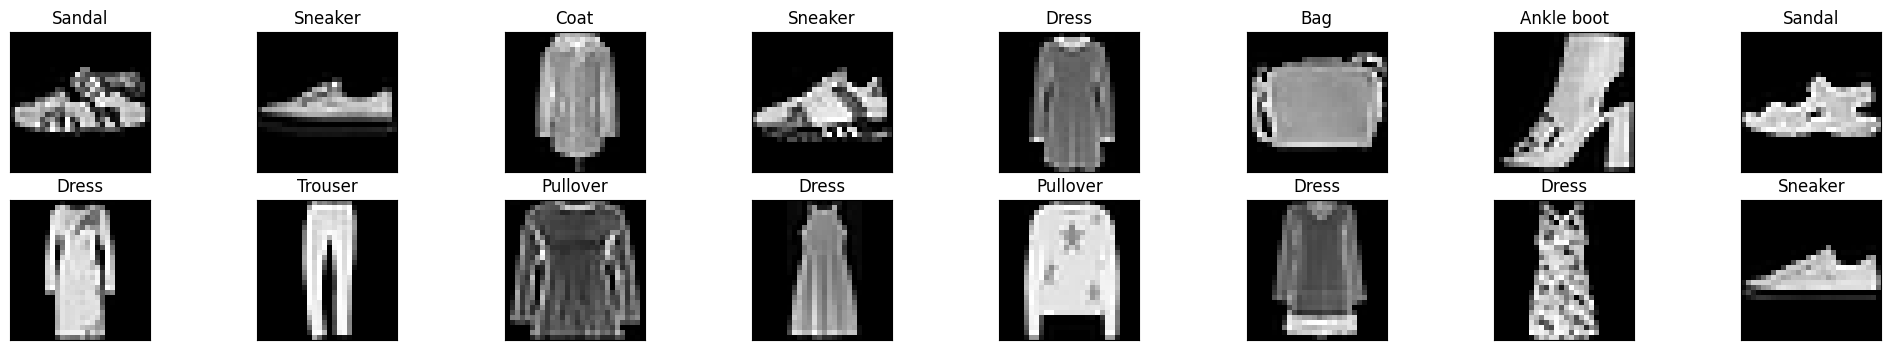

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(train_data.classes[labels[idx].item()]))

Создаем полносвязаннную нейронную сеть. 

In [ ]:
class ModelRunner:
  def __init__(self, model, optimizer, loss, epochs = N_EPOCHS, traindata = train_loader, testdata = test_loader):
    self.traindata = traindata
    self.testdata = testdata
    self.epochs = epochs
    self.init_model(model, optimizer, loss)
    self.can_cuda()

  def init_model(self, model, optimizer, loss):
    self.model = model
    self.optimizer = optimizer
    self.loss = loss

  def can_cuda(self):
    if torch.cuda.is_available():
      self.model.cuda()
      self.device = torch.device('cuda')
    else:
      self.device = torch.device('cpu')


  def print_n_log(self, correct, iloss, name = 'Train'):
    myset = self.traindata if name == 'Train' else self.testdata
    predicted_well =correct / len(myset.dataset)
    tqdm.write(f'{name}: Avg loss: {iloss} Accuracy: {round(100 * predicted_well,3)}%')   
    if WNB_FLAG:
      wandb.log({name+'_loss':iloss, 
                 name+'_accuracy':predicted_well})

  def get_correct_score(self, predictions, target):
      pred_p = predictions.argmax(dim=1, keepdim=True) 
      correct_mask = pred_p.eq(target.view_as(pred_p)) 
      return correct_mask.sum().item()                 

  def train(self):
    correct = 0 
    self.model.train()  
    for _batch_idx, (data, target) in tqdm(enumerate(self.traindata), total=len(self.traindata)):
      data = data.to(self.device)
      target = target.to(self.device)
      self.optimizer.zero_grad()                         

      preds = self.model(data)                         
      correct += self.get_correct_score(preds, target) 

      train_loss = self.loss(preds, target)            
      train_loss.backward()                                                       
      self.optimizer.step()                           

    self.print_n_log(correct, train_loss)              


  def test(self):
    correct = 0
    self.model.eval()  
    with torch.no_grad():                               
      for data, target in self.testdata:
        data = data.to(self.device)
        target = target.to(self.device)

        preds = self.model(data)                          
        correct += self.get_correct_score(preds, target)  
        test_loss = self.loss(preds, target)              

    self.print_n_log(correct, test_loss, 'Test')          

  def run_loop(self):
    print('TOTAL EPOCHS:', self.epochs)
    for epoch in range(self.epochs+1):
      print('Epoch:', epoch)
      self.train()
      self.test()
      print()

In [ ]:
def log_wnb(model):
  if WNB_FLAG:
    os.environ["WANDB_API_KEY"] = API_KEY
    wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, reinit=True, config=PARAM_DICT)
    wandb.watch(model, log='all')

In [ ]:
def mainloop(model, optimizer, loss, epochs):
  seed_all(SEED)
  runner = ModelRunner(model, optimizer, loss, epochs = epochs)
  log_wnb(model)
  runner.run_loop()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun Apr 30 10:52:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    30W /  70W |    599MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()
    hidden1 = 128
    hidden2 = 256
    hidden3 = 128
    self.fc1 = nn.Linear(N_IN, hidden1)
    self.fc2 = nn.Linear(hidden1, hidden2)
    self.fc3 = nn.Linear(hidden2, hidden3)
    self.fc4 = nn.Linear(hidden3, N_OUT)

  def forward(self, x):
    x = torch.flatten(x, 1) #x.view(-1, N_IN)
    x = nn_funcs.relu(self.fc1(x))
    x = nn_funcs.relu(self.fc2(x))
    x = nn_funcs.relu(self.fc3(x))
    #x = nn_funcs.softmax(self.fc4(x),dim=1)
    return self.fc4(x)

Запускаем обучение. Цель - получить на тесте значение accuracy не менее 88%.

In [ ]:
model = MyNet()
loss = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

mainloop(model, optimizer, loss, 10)

wandb: Currently logged in as: majesty50. Use `wandb login --relogin` to force relogin


TOTAL EPOCHS: 10
Epoch: 0


100%|██████████| 938/938 [00:18<00:00, 50.76it/s]

Train: Avg loss: 7.141531467437744 Accuracy: 82.283%


Test: Avg loss: 88.76617431640625 Accuracy: 84.58%

Epoch: 1


100%|██████████| 938/938 [00:15<00:00, 60.06it/s]

Train: Avg loss: 14.8982572555542 Accuracy: 86.887%


Test: Avg loss: 72.30016326904297 Accuracy: 85.8%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 57.70it/s]


Train: Avg loss: 8.207539558410645 Accuracy: 88.26%
Test: Avg loss: 68.65478515625 Accuracy: 86.02%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 57.37it/s]

Train: Avg loss: 11.336384773254395 Accuracy: 89.203%


Test: Avg loss: 64.5089340209961 Accuracy: 87.55%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 59.29it/s]


Train: Avg loss: 9.967679023742676 Accuracy: 89.658%
Test: Avg loss: 59.42921447753906 Accuracy: 87.89%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 55.83it/s]

Train: Avg loss: 5.500367641448975 Accuracy: 90.277%


Test: Avg loss: 66.2109603881836 Accuracy: 87.7%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 56.69it/s]

Train: Avg loss: 6.837122917175293 Accuracy: 90.703%


Test: Avg loss: 64.01933288574219 Accuracy: 88.52%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 59.67it/s]

Train: Avg loss: 5.889111518859863 Accuracy: 91.272%


Test: Avg loss: 67.17884063720703 Accuracy: 88.18%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 56.42it/s]

Train: Avg loss: 9.598129272460938 Accuracy: 91.462%


Test: Avg loss: 75.39816284179688 Accuracy: 88.03%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 60.20it/s]

Train: Avg loss: 13.044454574584961 Accuracy: 92.01%


Test: Avg loss: 64.82139587402344 Accuracy: 88.71%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 59.01it/s]

Train: Avg loss: 11.24782657623291 Accuracy: 92.288%


Test: Avg loss: 65.6064224243164 Accuracy: 88.61%



Пробуем другие оптимизаторы.

In [ ]:
model = MyNet()
loss = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01, weight_decay = 0.0001, betas=(0.9, 0.999))

mainloop(model, optimizer, loss, 10)

Test_accuracy,▁▂▄▆▆▆█▇█▇█
Test_loss,█▅▄▂▁▁▂▁▂▃▃
Train_accuracy,▁▄▅▆▆▇▇▇▇██
Train_loss,▃█▃▆▆▃▃▁▇▆▄
Test_accuracy,0.8843
Test_loss,71.50879
Train_accuracy,0.92033
Train_loss,9.24235


TOTAL EPOCHS: 10
Epoch: 0


100%|██████████| 938/938 [00:16<00:00, 56.40it/s]

Train: Avg loss: 7.289623737335205 Accuracy: 82.328%


Test: Avg loss: 78.06119537353516 Accuracy: 85.35%

Epoch: 1


100%|██████████| 938/938 [00:16<00:00, 57.25it/s]

Train: Avg loss: 11.593793869018555 Accuracy: 86.67%


Test: Avg loss: 71.6146011352539 Accuracy: 86.32%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 54.58it/s]

Train: Avg loss: 7.3405656814575195 Accuracy: 87.995%


Test: Avg loss: 73.21412658691406 Accuracy: 86.52%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 52.02it/s]

Train: Avg loss: 9.324446678161621 Accuracy: 88.847%


Test: Avg loss: 63.98028564453125 Accuracy: 87.31%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 56.85it/s]

Train: Avg loss: 12.710515975952148 Accuracy: 89.428%


Test: Avg loss: 63.430484771728516 Accuracy: 87.61%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 57.49it/s]

Train: Avg loss: 4.248976230621338 Accuracy: 89.988%


Test: Avg loss: 62.51276397705078 Accuracy: 87.84%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 51.67it/s]

Train: Avg loss: 9.667431831359863 Accuracy: 90.39%


Test: Avg loss: 58.66328811645508 Accuracy: 88.13%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 53.95it/s]

Train: Avg loss: 8.614699363708496 Accuracy: 90.728%


Test: Avg loss: 79.23637390136719 Accuracy: 87.73%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 52.61it/s]

Train: Avg loss: 11.561656951904297 Accuracy: 91.133%


Test: Avg loss: 76.6326904296875 Accuracy: 87.29%

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 49.84it/s]

Train: Avg loss: 9.117907524108887 Accuracy: 91.533%


Test: Avg loss: 82.34922790527344 Accuracy: 87.95%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 55.02it/s]

Train: Avg loss: 10.11794662475586 Accuracy: 91.835%


Test: Avg loss: 67.67620849609375 Accuracy: 88.23%



In [ ]:
model = MyNet()
loss = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.001)

mainloop(model, optimizer, loss, 10)

Test_accuracy,▁▃▄▆▆▇█▇▆▇█
Test_loss,▇▅▅▃▂▂▁▇▆█▄
Train_accuracy,▁▄▅▆▆▇▇▇▇██
Train_loss,▄▇▄▅█▁▅▅▇▅▆
Test_accuracy,0.8823
Test_loss,67.67621
Train_accuracy,0.91835
Train_loss,10.11795


TOTAL EPOCHS: 10
Epoch: 0


100%|██████████| 938/938 [00:15<00:00, 58.68it/s]

Train: Avg loss: 7.680642127990723 Accuracy: 81.908%


Test: Avg loss: 81.51885223388672 Accuracy: 85.72%

Epoch: 1


100%|██████████| 938/938 [00:16<00:00, 57.02it/s]

Train: Avg loss: 13.469208717346191 Accuracy: 86.928%


Test: Avg loss: 74.82416534423828 Accuracy: 86.49%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 59.17it/s]

Train: Avg loss: 7.369452953338623 Accuracy: 88.187%


Test: Avg loss: 69.21446228027344 Accuracy: 86.81%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 59.76it/s]

Train: Avg loss: 15.73735237121582 Accuracy: 89.073%


Test: Avg loss: 70.3327865600586 Accuracy: 87.15%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 59.19it/s]

Train: Avg loss: 10.579608917236328 Accuracy: 89.612%


Test: Avg loss: 58.3533821105957 Accuracy: 87.62%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 58.22it/s]

Train: Avg loss: 2.468437433242798 Accuracy: 90.257%


Test: Avg loss: 66.5798568725586 Accuracy: 87.57%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 56.49it/s]

Train: Avg loss: 7.811959266662598 Accuracy: 90.583%


Test: Avg loss: 64.40892028808594 Accuracy: 88.34%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 58.76it/s]

Train: Avg loss: 6.183806419372559 Accuracy: 91.085%


Test: Avg loss: 69.80012512207031 Accuracy: 88.04%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 59.27it/s]

Train: Avg loss: 9.67729377746582 Accuracy: 91.327%


Test: Avg loss: 68.94673156738281 Accuracy: 88.15%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 58.46it/s]

Train: Avg loss: 11.561774253845215 Accuracy: 91.77%


Test: Avg loss: 68.6435317993164 Accuracy: 88.74%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 58.72it/s]

Train: Avg loss: 8.637772560119629 Accuracy: 92.043%


Test: Avg loss: 64.23873901367188 Accuracy: 88.39%



In [ ]:
model = MyNet()
loss = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.AdamW(model.parameters(), lr = LR, weight_decay = 0.001)

mainloop(model, optimizer, loss, 10)

Test_accuracy,▁▃▄▄▅▅▇▆▇█▇
Test_loss,█▆▄▅▁▃▃▄▄▄▃
Train_accuracy,▁▄▅▆▆▇▇▇███
Train_loss,▄▇▄█▅▁▄▃▅▆▄
Test_accuracy,0.8839
Test_loss,64.23874
Train_accuracy,0.92043
Train_loss,8.63777


TOTAL EPOCHS: 10
Epoch: 0


100%|██████████| 938/938 [00:16<00:00, 55.82it/s]

Train: Avg loss: 9.910683631896973 Accuracy: 80.418%


Test: Avg loss: 109.7454833984375 Accuracy: 82.82%

Epoch: 1


100%|██████████| 938/938 [00:16<00:00, 57.79it/s]

Train: Avg loss: 14.78787899017334 Accuracy: 84.262%


Test: Avg loss: 96.92772674560547 Accuracy: 83.38%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 58.17it/s]

Train: Avg loss: 8.623982429504395 Accuracy: 85.41%


Test: Avg loss: 101.30730438232422 Accuracy: 84.32%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 56.29it/s]

Train: Avg loss: 14.56482982635498 Accuracy: 85.983%


Test: Avg loss: 106.91699981689453 Accuracy: 84.41%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 57.94it/s]

Train: Avg loss: 15.805238723754883 Accuracy: 85.863%


Test: Avg loss: 80.97319793701172 Accuracy: 85.32%

Epoch: 5


100%|██████████| 938/938 [00:16<00:00, 57.87it/s]

Train: Avg loss: 7.152149677276611 Accuracy: 86.468%


Test: Avg loss: 94.51213073730469 Accuracy: 85.18%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 55.52it/s]

Train: Avg loss: 13.998640060424805 Accuracy: 86.755%


Test: Avg loss: 109.6235122680664 Accuracy: 84.69%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 57.99it/s]

Train: Avg loss: 12.692087173461914 Accuracy: 87.043%


Test: Avg loss: 91.71432495117188 Accuracy: 85.42%

Epoch: 8


100%|██████████| 938/938 [00:16<00:00, 58.22it/s]

Train: Avg loss: 15.313188552856445 Accuracy: 86.507%


Test: Avg loss: 98.0782241821289 Accuracy: 85.12%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 52.89it/s]

Train: Avg loss: 16.34757423400879 Accuracy: 87.502%


Test: Avg loss: 88.8570327758789 Accuracy: 85.3%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 58.33it/s]

Train: Avg loss: 13.119001388549805 Accuracy: 87.517%


Test: Avg loss: 87.03697967529297 Accuracy: 85.62%



Может стоить добавить еще пару слоев? Как уже говорилось ранее, deep learning - это пространство для экспериментов и творчества. Дерзайте!